### Transformer Architecture

In [15]:
import torch
import torch.nn as nn
import math

class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.scale = math.sqrt(d_k)

    def forward(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        if mask is not None:
            attn_scores = attn_scores + mask
        attn_weights = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        return output, attn_weights


In [16]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_k = d_model // n_heads
        self.n_heads = n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.attn = ScaledDotProductAttention(self.d_k)

    def forward(self, x, mask=None):
        B, T, C = x.size()
        Q = self.W_q(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(B, T, self.n_heads, self.d_k).transpose(1, 2)

        out, attn_weights = self.attn(Q, K, V, mask)
        out = out.transpose(1, 2).contiguous().view(B, T, C)
        return self.W_o(out)


In [17]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))


In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


In [19]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(d_model, n_heads)
        self.ff = PositionwiseFeedForward(d_model, d_ff)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_out = self.attn(x, mask)
        x = self.ln1(x + self.dropout(attn_out))
        ff_out = self.ff(x)
        x = self.ln2(x + self.dropout(ff_out))
        return x


In [20]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, d_ff, num_layers, max_len, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([
            TransformerEncoderBlock(d_model, n_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        for layer in self.layers:
            x = layer(x, mask)
        ln_out = self.ln_f(x)
        logits = self.fc_out(ln_out)
        return logits

#### A simple tokenizer

In [21]:
vocab_str = "<pad> <bos> <eos> the cat is sat sitting by door dog barking mat open blue hello world mango sweet this scenario awesome Lorem ipsum dolor sit amet consectetur adipiscing elit Cras interdum quis ligula at ultricies Aliquam ullamcorper elit id fringilla pretium leo sapien posuere ex, eget placerat diam elit et turpis. Morbi tortor eros, vehicula quis consequat a, tempus vitae est Nunc congue lobortis turpis a tincidunt Quisque non accumsan ante ."

class vocabulary():
  def __init__(self, vocab_str):
    self.vocab = {word: index for index, word in enumerate(set(vocab_str.split(" ")))}
    self.inv_vocab = {index: word for word, index in self.vocab.items()}

  # text → list of token ids
  def tokenize(self, text):
      tokens = text.lower().split()
      return [self.vocab.get(token, 0) for token in tokens]

  # list of token ids → text
  def detokenize(self, token_ids):
    return ' '.join([self.inv_vocab.get(tid, "<unk>") for tid in token_ids])

tokenizer = vocabulary(vocab_str)

In [22]:
def causal_mask(size):
  # [size, size] matrix with upper triangle -inf, and rest 0
    mask = torch.triu(torch.ones(size, size), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask

### Model and configs

In [23]:
pad_token_id = tokenizer.vocab["<pad>"]
eos_token_id = tokenizer.vocab["<eos>"]
print(pad_token_id, eos_token_id)

20 29


In [24]:
device = torch.device('cpu')

In [25]:
model = TransformerEncoder(
  vocab_size=len(tokenizer.vocab),
  d_model=32,
  n_heads=8,
  d_ff=256,
  num_layers=4,
  max_len=100
).to(device)

In [26]:
import torch.optim as optim
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


#### Autoregressive Loop

In [27]:
len(tokenizer.vocab)

70

In [28]:
def autoregressive_generation(model, prompt_tokens, max_new_tokens=20, eos_token_id=2, device='cpu'):

    input_ids = torch.tensor([prompt_tokens], dtype=torch.long, device=device)
    model.eval()

    for _ in range(max_new_tokens):

        seq_len = input_ids.size(1)
        mask = causal_mask(seq_len).to(device)
        mask = mask.unsqueeze(0).unsqueeze(0)  # (1, 1, T, T)

        with torch.no_grad():
            logits = model(input_ids, mask)  # (1, seq_len, vocab_size)

        next_token_logits = logits[0, -1, :]  # (vocab_size,)

        # Using softmax on logits to get the probability vector
        probs = torch.softmax(next_token_logits, dim=-1)

        # Greedy Decoding
        next_token_id = torch.argmax(probs).item()

        input_ids = torch.cat([input_ids, torch.tensor([[next_token_id]], device=device)], dim=1)
        if next_token_id == eos_token_id:
            break

    output_token_ids = input_ids[0].tolist()
    return output_token_ids


### Trying on sample text

In [29]:
sample_text = "the cat is sitting by the door <eos> the mango is sweet"

def prepare_sample_text(sample_text):
  sample_text_list = sample_text.split(" ")
  sample_text_list.append("<eos>")
  sample_tokens = [tokenizer.vocab[w] for w in sample_text_list]
  return sample_tokens


In [30]:
# A dataset with repetitive batch
def create_sample_dataset(seq, batch_size=2):
    inputs = []
    targets = []
    for _ in range(batch_size):
        inputs.append(seq[:-1])   # all but last token
        targets.append(seq[1:])   # all but first token
    return torch.tensor(inputs), torch.tensor(targets)

#### Train loop

In [31]:
import matplotlib.pyplot as plt

n_epochs = 300
batch_size = 5
loss_history = []

for epoch in range(n_epochs):

    tokens = prepare_sample_text(sample_text)
    inputs, targets = create_sample_dataset(tokens, batch_size)
    inputs, targets = inputs.to(device), targets.to(device)

    seq_len = inputs.size(1)
    mask = causal_mask(seq_len).to(device)
    mask = mask.unsqueeze(0).unsqueeze(0)  # shape (1, 1, T, T)

    logits = model(inputs, mask)

    probs = torch.softmax(logits, dim=-1)

    # Reshaping for CE loss: (B*T, vocab_size) vs (B*T)
    logits = logits.view(-1, logits.size(-1))
    targets = targets.view(-1)

    # Compute loss
    loss = loss_fn(logits, targets)
    loss_history.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 50, Loss: 0.5053
Epoch 100, Loss: 0.1535
Epoch 150, Loss: 0.0742
Epoch 200, Loss: 0.0448
Epoch 250, Loss: 0.0303
Epoch 300, Loss: 0.0220


#### Plotting the loss curve

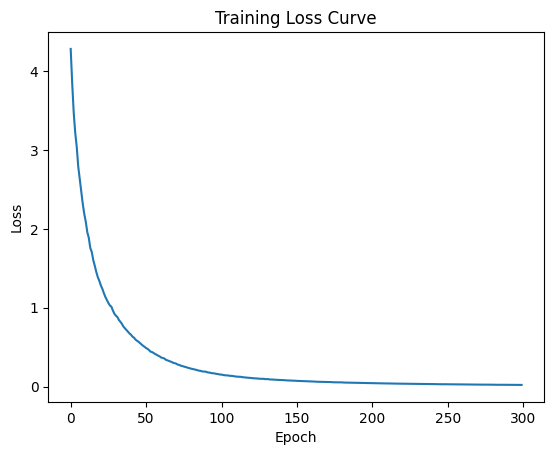

In [32]:
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

In [33]:
def generate_from_prompt(prompt):
  prompt_tokens = tokenizer.tokenize(prompt)
  output_tokens = autoregressive_generation(model, prompt_tokens, max_new_tokens=10, eos_token_id=eos_token_id)
  output_text = tokenizer.detokenize(output_tokens).replace("<eos>", "")
  return output_text

prompt = "the mango"
print(generate_from_prompt(prompt))

the mango is sitting by the door 


### Training on multiple sentences

In [ ]:
sentences = [
    "the cat sat by the mat <eos>",
    "the cat is sitting by the door <eos>",
    "mango is sweet <eos>",
    "the mat is blue <eos>",
    "the door is open <eos>"
]

In [35]:
import random
from torch.nn.utils.rnn import pad_sequence

max_token_length = 8

def create_batch(dataset, batch_size=2):
    inputs, targets = [], []
    for _ in range(batch_size):
        seq = random.choice(dataset)
        tokens = torch.tensor(prepare_sample_text(seq))
        inputs.append(tokens[:-1])
        targets.append(tokens[1:])

    inputs = pad_sequence(inputs, batch_first=True, padding_value=pad_token_id)
    targets = pad_sequence(targets, batch_first=True, padding_value=pad_token_id)
    return torch.tensor(inputs), torch.tensor(targets)

In [36]:
import matplotlib.pyplot as plt

n_epochs = 300
batch_size = 5
loss_history = []

for epoch in range(n_epochs):
    inputs, targets = create_batch(sentences, batch_size)
    inputs, targets = inputs.to(device), targets.to(device)

    seq_len = inputs.size(1)
    mask = causal_mask(seq_len).to(device)
    mask = mask.unsqueeze(0).unsqueeze(0)  # shape (1, 1, T, T)

    logits = model(inputs, mask)
    probs = torch.softmax(logits, dim=-1)

    # Reshaping for CE loss: (B*T, vocab_size) vs (B*T)
    logits = logits.view(-1, logits.size(-1))
    targets = targets.view(-1)

    loss = loss_fn(logits, targets)
    loss_history.append(loss.item())

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 50 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


/tmp/ipython-input-35-2615041147.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(inputs), torch.tensor(targets)


Epoch 50, Loss: 0.3021
Epoch 100, Loss: 0.2262
Epoch 150, Loss: 0.2049
Epoch 200, Loss: 0.1609
Epoch 250, Loss: 0.1573
Epoch 300, Loss: 0.1541


In [37]:
prompt = "the mat"
print(generate_from_prompt(prompt))

the mat is blue 
